In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io
from medpy.io import load,header

In [39]:
def load_CT_image(filepath):
    CT_image_data, CT_image_header = load(filepath)
    CT_image_origin = header.get_offset(CT_image_header)
    CT_image_spacing = header.get_pixel_spacing(CT_image_header)
    return CT_image_data, CT_image_origin, CT_image_spacing

In [40]:
'''
    Convert world coordinate to voxel coordinate
'''
def world2voxelcoord(worldCoord, origin, spacing):
    return (np.absolute(worldCoord - origin)/ spacing).astype(int)

In [75]:
'''
     CTScan Class get file path, folder path(dicom directory) as input source.
     It automatically read data from medical image and extract nessary data.
     v1.2
'''
class CTScan:
    def __init__(self, filepath):
        self.filepath = filepath
        self.CT_image_data,self.CT_image_origin,self.CT_image_spacing = load_CT_image(filepath)
        self.space = self.CT_image_data.shape
    '''
        Understand about X,Y,Z : https://www.slicer.org/wiki/File:Coordinate_sytems.png
    '''
    def getData(self):
        return self.CT_image_data
    def getOrigin(self):
        return self.CT_image_origin
    def getSpacing(self):
        return self.CT_image_spacing
    '''
        coordX, coordY, coordZ is voxel coordinate. If you want to apply world coordinate, use world2voxelcoord() function to transform before use.
    '''
    def getPlaneX(self, coordX):
        return self.CT_image_data[coordX,0:self.space[1],0:self.space[2]]
    def getPlaneY(self, coordY):
        return self.CT_image_data[0:self.space[0],coordY,0:self.space[2]]
    def getPlaneZ(self, coordZ):
        return self.CT_image_data[0:self.space[0],0:self.space[1],coordZ]
    '''
        Return the image in a range of HU in range [0,1]
    '''
    @staticmethod
    def huSegmentation(image_data, minHU, maxHU):
        image_data = (image_data - minHU) / (maxHU - minHU)
        image_data[image_data > 1] = 1
        image_data[image_data < 0] = 0 
        return image_data
    '''
        Return the image in a range of HU in range [minHU,maxHU]
    '''
    @staticmethod
    def huSegmentation_v2(image_data, minHU, maxHU):
        image_data[image_data > maxHU] = maxHU
        image_data[image_data < minHU] = minHU 
        return image_data
    '''
        convert segmented HU image to gray scale
    '''
    @staticmethod
    def hu2png(image_data):
        return (image_data*225//1).astype(np.uint8)
    '''
        Image left to right is corresponding to left to right of patient
        Image top to bottom is corresponding to back to front of patient
    '''
    def planeZ_to_imageview(self,coordZ):
        return np.swapaxes(self.getPlaneZ(coordZ),0,1)
    '''
        Image left to right is corresponding to back to front of patient
        Image top to bottom is corresponding to top to bottom of patient
    '''
    def planeX_to_imageview(self,coordX):# view from 
        return np.fliplr(np.rot90(self.getPlaneX(coordX)))
    '''
        Image back to front is corresponding to back to front of patient
        Image top to bottom is corresponding to top to bottom of patient
    '''
    def planeY_to_imageview(self,coordY):#
        return np.rot90(self.getPlaneY(coordY))

In [14]:
newCTScan = CTScan("/storage/shared/luna_data/1.3.6.1.4.1.14519.5.2.1.6279.6001.986011151772797848993829243183.mhd")
filepath = "/storage/shared/luna_data/"
fileExtensionName = ".mhd"
annotations = pd.read_csv('/storage/huybq/downloads/annotations.csv')

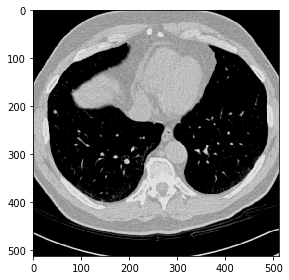

In [74]:
for index,row in annotations.iterrows():
    if index == 0:
        fileName = row["seriesuid"]
        curCTScan = CTScan(filepath+fileName+fileExtensionName)
        
        worldCoord = np.asarray([float(row["coordX"]),float(row["coordY"]),float(row["coordZ"])])
        voxelCoord = world2voxelcoord(worldCoord , curCTScan.getOrigin() , curCTScan.getSpacing())
        img = CTScan.hu2png(CTScan.huSegmentation(curCTScan.planeZ_to_imageview(voxelCoord[2]),-800,200))
#         diffutionImg = smoothing.anisotropic_diffusion(normalizePlanes2img(wholePatch,"non-solid"),niter = 10, kappa = 2, gamma = 0.0625,voxelspacing = None, option = 3)
        io.imshow(img,cmap = plt.cm.gray)
        break